In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import einops

from visionts import VisionTS

### Load the model

In [2]:
ARCH = 'mae_base' # choose from {'mae_base', 'mae_large', 'mae_huge'}. We recommend 'mae_base'
DEVICE = 'cuda:0'

ckpt_dir = '/home/mouxiangchen/uni2ts/outputs/pretrain/visionts/lotsa_v1_weighted/weighted_7_quantile_512_multi_color_9_heads/checkpoints'
# ckpt_path = f'{ckpt_dir}/epoch=99-step=10000.ckpt'
ckpt_path = f'{ckpt_dir}/processed_epoch=99-step=10000.ckpt'
    
model = VisionTS(ARCH, ckpt_path=ckpt_path, quantile=True, 
                    clip_input=True, complete_no_clip=False, color=True).to(DEVICE)

Load /home/mouxiangchen/uni2ts/outputs/pretrain/visionts/lotsa_v1_weighted/weighted_7_quantile_512_multi_color_9_heads/checkpoints/processed_epoch=99-step=10000.ckpt


/home/mouxiangchen/uni2ts/scripts/VisionTS/visionts/model.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


In [3]:
model

VisionTS(
  (vision_model): MaskedAutoencoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
         

### Define util functions

In [4]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

# def show_image(image, title=''):
def show_image(image, title='', cur_nvars=1, cur_color_list=None):
    # image is [H, W, 3]
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    assert image.shape[2] == 3
    
    # plt.imshow(torch.clip((image.cpu() * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    # plt.title(title, fontsize=16)
    # plt.axis('off')
    
    # ! old solution:
    # cur_image = (image.cpu() * imagenet_std + imagenet_mean) * 255
    # cur_image = torch.clip(cur_image, 0, 255).int()
    
    # ! 20250430 adds: 根据color_list来处理图片的颜色通道
    # channel_masks = (image != 0).any(dim=(0, 1))
    cur_image = torch.zeros_like(image)
    cur_image = cur_image.cpu()
    
    height_per_var = image.shape[0] // cur_nvars
    print(f"{height_per_var = }, {image.shape = }, {cur_nvars = }")
    for i in range(cur_nvars):
        cur_color = cur_color_list[i]
        cur_image[i*height_per_var:(i+1)*height_per_var, :, cur_color] = \
            (image[i*height_per_var:(i+1)*height_per_var, :, cur_color].cpu() * imagenet_std[cur_color] + imagenet_mean[cur_color]) * 255
    cur_image = torch.clip(cur_image, 0, 255).int()
    
    
    plt.imshow(cur_image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    
    
    # 最后再保存一下两幅子图！！
    

def run(x, y, periodicity, nvars=1, color_list=None):
    # The input of VisionTS is a Tensor with shape [n_batch, context_len, n_vars]
    x = torch.Tensor(einops.rearrange(x, 't m -> 1 t m')).to(DEVICE)
    # The output of VisionTS is a Tensor with shape [n_batch, pred_len, n_vars]
    y = torch.Tensor(einops.rearrange(y, 't m -> 1 t m')).to(DEVICE)
    
    # # Before calling forward, make sure you use update_config() to update hyperparameters, context length or prediction length.
    # model.update_config(x.shape[1], y.shape[1], align_const=align_const, norm_const=norm_const, periodicity=periodicity)
    
    model.update_config(context_len=x.shape[1], pred_len=y.shape[1], periodicity=periodicity, 
                        num_patch_input=7, padding_mode='constant')
    
    # Forecasting time series using forward()
    with torch.no_grad():
        y_pred, input_image, reconstructed_image = model.forward(x, export_image=True, color_list=color_list)

    # 这里返回的是一个list，包含了预测值和对应的置信区间的值！！
    y_pred, y_pred_quantile_list = y_pred
    
    
    # Visualization
    x = x[:, -300:, :]
    plt.subplot(2, 2, 1)
    show_image(input_image[0, 0], 'input', nvars, color_list)

    plt.subplot(2, 2, 2)
    plt.plot(x.cpu()[0, :, 0])
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y.cpu()[0, :, 0], label='true', alpha=0.5)
    # plt.title('input time series')
    plt.title(f'input time series {nvars} vars')
    plt.legend()
    plt.tight_layout()

    plt.subplot(2, 2, 3)
    show_image(reconstructed_image[0, 0], 'reconstructed', nvars, color_list)

    plt.subplot(2, 2, 4)
    plt.plot(x.cpu()[0, :, 0])
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y.cpu()[0, :, 0], label='true', alpha=0.5)
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y_pred.cpu()[0, :, 0], label='pred')
    
    if y_pred_quantile_list is not None:
        print(f"{len(y_pred_quantile_list) = }")
        for j, y_pred_quantile in enumerate(y_pred_quantile_list):
            print(f"y_pred_quantile_list[{j}].shape: {y_pred_quantile.shape}")
            if j < len(y_pred_quantile_list) // 2:
                plt.plot(torch.arange(y.shape[1]) + x.shape[1], y_pred_quantile.cpu()[0, :, 0], label=f'pred_{10*(j+1)}', color=f'C{j+2}', alpha=0.5)
            else:
                plt.plot(torch.arange(y.shape[1]) + x.shape[1], y_pred_quantile.cpu()[0, :, 0], label=f'pred_{10*(j+2)}', color=f'C{j+2}', alpha=0.5)
    
    # plt.title('forecasting')
    plt.title(f'period={periodicity} ctx={x.shape[1]}, pred={y.shape[1]}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
    # 再保存一下！！
    def save_image(image, title='', cur_nvars=1, cur_color_list=None, save_path='image.pdf'):
        # image is [H, W, 3]
        imagenet_mean = np.array([0.485, 0.456, 0.406])
        imagenet_std = np.array([0.229, 0.224, 0.225])
        assert image.shape[2] == 3
        
        # ! 20250430 adds: 根据color_list来处理图片的颜色通道
        # channel_masks = (image != 0).any(dim=(0, 1))
        cur_image = torch.zeros_like(image)
        cur_image = cur_image.cpu()
        
        height_per_var = image.shape[0] // cur_nvars
        print(f"{height_per_var = }, {image.shape = }, {cur_nvars = }")
        for i in range(cur_nvars):
            cur_color = cur_color_list[i]
            cur_image[i*height_per_var:(i+1)*height_per_var, :, cur_color] = \
                (image[i*height_per_var:(i+1)*height_per_var, :, cur_color].cpu() * imagenet_std[cur_color] + imagenet_mean[cur_color]) * 255
        cur_image = torch.clip(cur_image, 0, 255).int()
        
        plt.plot(figsize=(10, 10))
        plt.imshow(cur_image)
        plt.title(title, fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()
    
    save_image(input_image[0, 0], 'input', nvars, color_list, save_path='input.pdf')
    save_image(reconstructed_image[0, 0], 'reconstructed', nvars, color_list, save_path='reconstructed.pdf')
    
    

### Forecasting Monash Dataset

- Example 1: a time-series with significant periodicity.

We use P = 30.
x shape = (180, 4), y shape = (180, 4)
self.nvars = 4
image_input.shape = torch.Size([1, 3, 224, 224])
image_input > 2.2489: False, image_input < -1.8044: False
height_per_var = 56, image.shape = torch.Size([224, 224, 3]), cur_nvars = 4
height_per_var = 56, image.shape = torch.Size([224, 224, 3]), cur_nvars = 4
len(y_pred_quantile_list) = 8
y_pred_quantile_list[0].shape: torch.Size([1, 180, 4])
y_pred_quantile_list[1].shape: torch.Size([1, 180, 4])
y_pred_quantile_list[2].shape: torch.Size([1, 180, 4])
y_pred_quantile_list[3].shape: torch.Size([1, 180, 4])
y_pred_quantile_list[4].shape: torch.Size([1, 180, 4])
y_pred_quantile_list[5].shape: torch.Size([1, 180, 4])
y_pred_quantile_list[6].shape: torch.Size([1, 180, 4])
y_pred_quantile_list[7].shape: torch.Size([1, 180, 4])


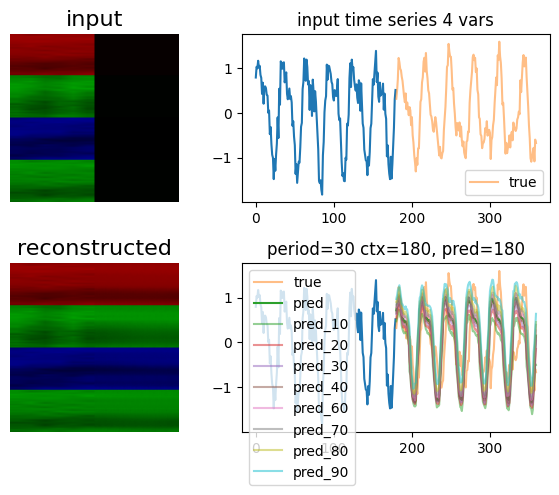

height_per_var = 56, image.shape = torch.Size([224, 224, 3]), cur_nvars = 4


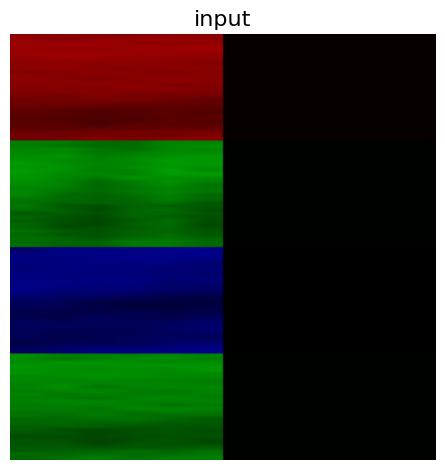

height_per_var = 56, image.shape = torch.Size([224, 224, 3]), cur_nvars = 4


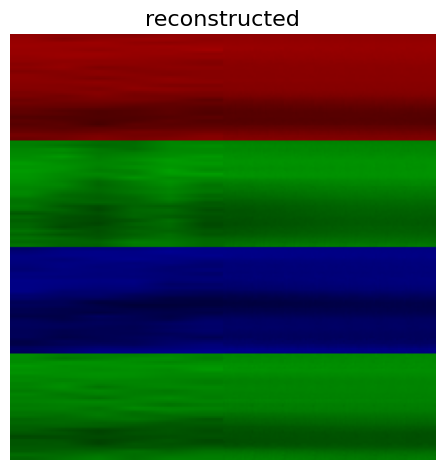

In [ ]:
import random

s1_in = [0.7945448502934656, 1.0345840944523612, 1.0004319684289473, 1.1701937956131003, 1.0180931113826883, 1.0567427313244646, 0.8521574330247161, 0.7875893481652716, 0.4273529379939971, 0.6787858659636581, 0.2080056426339719, 0.5893262265648964, 0.5964167909839531, 0.5580802864830064, 0.40611232107244527, 0.3907591058529969, 0.0032381075597729403, 0.05675828235519728, -0.47352890314813273, -0.31337359095513817, -0.6954650990953051, -0.9355918778724651, -1.0041924194473202, -1.4815559487545686, -1.0295636597377122, -1.2936847908596598, -0.9309874395762253, -0.6851739601085512, -0.09872835858569057, -0.5608966290516131, 0.5428673682631819, 0.18528825461467202, 1.1570731584826945, 1.0728817812336875, 0.9922713272121382, 1.1268024134916361, 1.1350562967658078, 0.6865049515001582, 0.7911873065099236, 0.9099703663071956, 0.43108022782697986, 0.3074668809294292, 0.42370847329936834, 0.5481774113490759, 0.31179757407073694, 0.3790983515472809, 0.23537296898173232, -0.28643408926466296, -0.18765546347108575, -0.5293710687674149, -0.7199683736020044, -1.3650094961459833, -1.144320016643332, -1.5654970710455494, -1.3286184100032434, -1.0899118265523398, -1.1134151154985574, -0.7683955067876915, -0.3074163506664655, -0.22127998618440733, 0.5350503031367944, 0.6976093548488855, 1.2214625732152153, 1.0885387644560411, 0.7220970192113176, 1.1961663573931411, 1.0308966233069654, 0.6384909549692335, 0.7162427928037702, 0.06848486668945436, 0.6246800331981117, 0.549203868335955, -0.06627186904840165, 0.747677062442552, 0.4842969622435574, 0.0364290669571713, 0.48813651007597814, 0.2638100549236864, -0.10544580290907124, -0.453064290375385, -0.8172237321768112, -1.5233196267729399, -1.5702492945708215, -1.5070026170219488, -1.7194422130068223, -1.828650191879572, -0.9442893415605252, -0.6480510996386482, 0.015036958070676898, 0.27965310816996625, 0.3750656167310618, 1.084051851957525, 0.7483636698072238, 1.0593363622694008, 1.0488426471013925, 0.9559035313552723, 0.8740500125300422, 0.698784604329126, 0.6468247442917512, 0.35733777761289376, 0.2797636828014289, 0.5123064993349395, 0.4186058837705621, 0.37896706189082724, 0.5381669995446929, 0.7596825378788375, -0.01687377571233295, -0.16081051737392768, -0.12037585084982888, -0.602258251527818, -1.0941823409164604, -1.4099197811945556, -1.3498853702759495, -1.5207914413362569, -1.528617066858977, -1.0032658636358798, -1.043947144453409, -0.23861801083623158, -0.28095988805626093, -0.039374269350224755, 0.7788048970830892, 1.1130946010163394, 0.5818581228556112, 1.195869539791846, 0.9747098317889897, 1.0273508707464127, 0.7437544190709644, 0.5992607327742022, 0.5026186759734994, 0.6417563962478225, 0.34349241764428334, 0.223992716431036, 0.7328650589306652, 0.6696910438688599, 0.050345144255758034, 0.6635188782202425, 0.21398582856716036, -0.23790308059312962, -0.33256922373265096, -0.8177146028171269, -0.9316095467590972, -1.0613281267694197, -1.0809811523872637, -1.3923972548808554, -0.9824113477171226, -1.1782229826622586, -0.8752265755944459, -0.3396729292588302, -0.24029063102767603, 0.229898026778882, 0.7577534770965583, 0.6326398694236648, 0.8877291542472958, 1.117352993519832, 1.3917832828087022, 0.6925771175303168, 0.904096600527861, 0.36757706348786123, 0.24983898638280833, 0.6805778819267566, 0.39024408881595846, 0.4426367987158944, 0.42346638654097546, 0.6578313236149999, 0.07507641229701673, 0.43378336354688507, -0.017448067969082437, -0.129445625093893, -0.9711458119851064, -0.7236442924533806, -1.148987125979815, -1.3596858678293497, -1.4824211587855411, -0.9799117424538276, -1.4686200248363974, -1.1427795215632222, -0.74711443099538, -0.33335557550419803, 0.30888160496509465, 0.5154624392909641]
s2_in = [0.578797097097873, 0.566755783700435, 0.9300289131444944, 1.068147990694198, 1.2125590028252915, 1.4205182706885302, 2.0003168444191046, 1.5689911719379865, 1.9659743221939312, 1.6849080424819873, 1.6379100848196282, 1.453091587555924, 1.218733539450575, 0.8624060805302121, 1.0803400870723086, 0.9331051874921648, 0.15422883746133448, 0.01290300571389344, 0.2608707849999441, -0.10005023574147803, -1.354710046808466, -0.3238603764616589, -1.0032026044722429, -0.563212249194819, -0.60513891763096, 0.05297250744110005, -0.6561158221018663, 0.04813547801605142, -0.5262294943944407, 0.14038580604282547, 0.5265549478543581, 0.0721804185348267, 1.3339632829644659, 0.9634705326596262, 1.854177512913359, 1.141402033186171, 1.2760949510903032, 1.5976954366169802, 1.385329914482207, 1.038020384896144, 0.9771603675232221, 0.737945061625273, 0.9392731977344918, 0.5271258245567709, 0.034802973283788674, -0.4967829151994053, -0.22513406445217785, -0.6715764101829035, -1.2312826816538711, -0.7057692983584414, -1.0324348985424259, -1.614884598197411, -1.4996004023311926, -1.6787645163370308, -1.9771226913397861, -0.8673500809082666, -1.5020130263224207, -0.5815990514687606, -0.6548207890086434, -0.664722436696492, -0.23780394494953816, -0.46313367992932, 0.2875499042449647, 0.26820976204622904, 0.4955775087246997, 0.6677191455711394, 0.8927811590590171, 0.7141456109132791, 0.42095408038195936, 1.0473448013028994, 0.3592325939860409, -0.389061404998483, -0.573653079680092, -0.37975380167459416, -0.46415736386157724, -0.8044352038034339, -0.8932931268315263, -0.6123151613104676, -1.7753598780075162, -1.990679555339178, -1.5245792738709754, -1.9114636618062706, -1.893157471814455, -2.2073291012303202, -1.5574933446315602, -1.653544243853118, -1.4733319323234502, -1.3188194343326394, -0.6471276720637347, -0.8038353046725271, -0.3522751492574232, -0.18266910496018796, -0.24422711646275896, 0.5319425200655532, 0.9215105864500546, 1.2830695257837168, 0.801401554891227, 1.4227902720042132, 0.7330396080862374, 0.7366647055210336, 1.661531577271387, 0.5306029909866616, 0.3103866845898199, 0.06816643610430134, 0.31216937735468847, -0.2540203633217002, -0.5367104580797231, -0.5441784726172724, -0.7092886706323724, -0.5085157467100573, -0.6312774972225127, -0.5428671913793359, -1.4942893487151194, -0.6210895465688762, -1.1577831965757732, -0.6482868810776042, -0.8993737533371557, -0.44542023142296316, 0.5905690728614809, 0.397386474194171, 0.8872058822176646, 0.9851311478392737, 0.9397786985061445, 1.1762769396373416, 1.311898063585626, 2.000203653654608, 1.8339011765737248, 1.6650522898087678, 2.2358728829807935, 1.9248892328234495, 1.0891332978093091, 1.4693606824915384, 1.245760208624871, 0.7635927809615969, 0.9322561707137121, 0.5673877685851298, 0.6568207087388849, 0.025989846673316663, -0.9364023024963308, -0.3364457636301408, -0.4784597312607817, -1.120788823842872, -0.04344463843495894, -0.3944122250547148, -0.4026523915253044, -0.7147977691122982, -0.18628651283523576, -0.08052776384249148, 0.3340697456595753, 0.42381029795576053, 0.68774967794409, 1.3609457228851127, 1.0682257197417218, 1.153776147576759, 1.8409458709488078, 1.428326347243774, 1.9148606365097667, 1.3365680178802943, 1.058311896330355, 2.1712702869760547, 1.1143606267955604, 0.6781411563612681, 0.018632609713473913, 0.09830160919378839, 0.1904282587681325, -0.6632936324765673, -0.3371103631807887, -1.2162953175312787, -1.1587941068517666, -1.6527640351894652, -1.306287145084723, -1.6520665974307596, -1.5820371899828094, -1.9786990651294363, -1.7078676170884681, -1.238379287630973, -1.3910690144572944, -0.674393952842613, -0.43446622780526634, -0.3967250136316855]
s1_out = [0.3190242994293003, 0.4961042798538928, 0.7547128542528414, 1.2327459881213694, 1.1383611940296525, 0.9905799342595688, 0.9561800444265612, 0.8116654571763617, 0.7184930832577051, 0.5395506782232984, 0.3682069763964023, 0.2419177154785887, 0.43854450860636907, 0.0842594459770731, 0.23500531449656278, 0.0958528443522677, -0.04931609546028756, 0.1310265103577633, 0.05750968835852181, -0.2725648127862291, -0.0924679762306796, -0.49638119092501015, -0.6649956152788037, -0.940270694612138, -1.1082488639079537, -1.3091682783033927, -1.014818299511876, -1.1597160716599217, -0.7920511791198764, -0.791587054526476, -0.23401084453755278, 0.248282885201089, 0.3091786126144619, 0.6865940716622861, 0.8042088555234036, 1.1511641786921183, 1.2372310917733886, 0.9282094844097024, 1.3443729011345074, 0.9415133687929995, 0.777645011559663, 0.5084872157185482, 0.4411703890435381, 0.19781792784823257, -0.03981765775707363, -0.07803977246163647, -0.18960178085045562, -0.37381524289381746, -0.421295514108916, -0.25949826389029507, -0.09290315283630203, -0.20318207618904913, -0.3931198732583746, -0.5763902591252922, -0.7791172877763611, -0.9511635200317082, -0.7583036750085124, -0.9971672977474237, -1.016989106157999, -0.9018893101564339, -0.8534917094877943, -0.38015006036725585, -0.10100058843373744, 0.14051405369956005, 0.5560325301485493, 1.0331062933869242, 1.0715805832577574, 1.5483523015979483, 1.3755659108058058, 1.2643855230589205, 1.2591766870992331, 0.9492233666204734, 0.5238498201765096, 0.5625414362732954, 0.20550718796952178, -0.014239659960362638, -0.3183876892280103, -0.5022575542660306, -0.2255984415756421, -0.33250878842679843, -0.39204508170812746, -0.21171854861697195, -0.5257119582451577, -0.30146833940175766, -0.6147357663737703, -0.7458774124094008, -0.6387094551854791, -0.8862034261421631, -0.9624525982956674, -1.0129722133716077, -0.6435324183803472, -0.6213263323474301, -0.4161847477489211, -0.42870303742412613, 0.22614927313166633, 0.5113196060107421, 0.7236626589640904, 0.9198542191928666, 1.254406787553887, 1.3068684575827658, 1.18365870296117, 1.2371313563127335, 0.9168129355864814, 0.9989057800226727, 0.5166603900067324, 0.41747686453992955, -0.09585798491447538, -0.13112846591405902, -0.4772822898993954, -0.5140550256708538, -0.7881941696379497, -0.6762434938197341, -0.6607137551748637, -0.5831785677942984, -0.339676420928206, -0.4283245526086311, -0.18433211641029024, -0.5074371828229306, -0.3874680549226989, -0.37695810421453757, -0.4414044752250833, -1.0309112294372667, -0.607846053536461, -0.5387922138874419, -0.2759880008902902, -0.15549593469488246, 0.21663635868885595, 0.5266855589778136, 0.79624907933322, 0.6234741898989273, 1.289941681991896, 1.186973852665279, 1.5971078293521768, 1.2699969137899745, 1.1199849705266496, 0.768611929347125, 0.18854611806049154, 0.23039725559469412, -0.10812229239691826, -0.5286007789246167, -0.9107808447652976, -0.6680828459566152, -0.8997078640939551, -0.7808965081077766, -0.7591184196161257, -0.5023217943809202, -0.771525229601487, -0.5021418674539582, -0.4220328682167478, -0.6119238769615947, -0.21430014838118366, -0.30178201652019215, -0.3536759829153578, -0.40263148836462787, -0.3474571600216197, -0.1458404155693127, -0.0981965632014205, 0.031293485756376534, -0.0271387198062763, 0.7312273459062333, 0.46837217032058975, 0.7890121013343673, 1.1353626555031293, 1.297778476163714, 1.0433769620627524, 1.084738123307074, 1.2409380974201405, 0.8022439695344955, 0.47457145675407586, 0.1454807719387188, -0.27566537361867605, -0.5642356328761104, -1.0125983545556276, -1.0921288983902684, -0.9918017293702921, -0.8665395181294102, -0.7806199459225582, -1.083544840181964, -0.5965845776193344, -0.6723735724470687]
s2_out = [0.08399128881266393, 0.4018074871377963, 0.9971774612615775, 1.042920257775894, 1.6491907267509132, 1.0355370756673614, 1.7706366351284601, 1.9011454070100433, 1.8841494211420953, 1.6113925393320245, 1.5102008614968838, 1.342630365843171, 1.178817475878315, 1.3610889605002734, 0.6978785022595697, 0.6053490153776233, 0.2799407923719195, 0.5410376423854002, -0.368509551641217, -0.3333282062746218, 0.1502746569930995, -0.4513892800757256, -0.6720564539110812, -0.18876338757876093, -0.9325855627831785, -0.6751126292743883, -0.11143180535133901, -0.3656975149077921, -0.36926375020990554, -0.2669827549709093, 0.0988881198943459, 0.7480402086306859, 0.4069485417191549, 0.7155003855951956, 1.0931347901777986, 1.0804802355799392, 0.6722182098486211, 1.705223817663365, 1.4772463114682648, 1.2459123606265834, 1.4881903156987477, 1.6414263578524524, 0.5878665547689403, 0.8502823668970875, 0.30593721326715556, 0.7633753876369481, 0.01926850384292106, -0.23426560434235844, -0.15155289412727468, -1.0467034747858186, -0.7954983288445104, -0.7180892393778442, -0.9236414324651959, -1.4283587104488726, -0.9613317855155672, -1.6612895504533045, -1.449049709609423, -1.4229611738011423, -1.4179807332245231, -0.35279598321320627, -1.0726802088944933, -0.12073417747758941, -0.30965326734754, 0.002164298534210879, -0.07512238237657205, 0.5405651857642978, 0.2841544336177435, 0.540908994688155, 0.4280912681727136, 0.22643794588058724, 0.18831164052660798, 0.2615002175569797, 0.7252785336038814, 0.2536955027808794, 0.07428980571633222, -0.033770625375192855, -0.2584109878739267, -0.9799223245448951, -0.44599467704975676, -0.8450078099693848, -0.91790614516567, -1.7406487103145, -1.6638717243589831, -1.5692569737494046, -1.8814183802102682, -1.984228052558408, -1.6884133016542897, -2.1038554540926215, -1.4617804815689928, -1.5783876253408708, -1.1954661322361908, -0.7377302655173423, -0.37957774740223543, -0.14111130064898686, 0.1802677496482583, 0.7244628294033049, 0.5528096438277555, 0.7477410221825708, 0.4188215969851048, 1.0362791709270454, 0.9200737594586941, 0.8416964649282421, 0.6763487520129342, 0.3886857809650047, 0.20983498620215635, 0.7301431520493292, 0.3768772203091894, 0.2993229931684627, -0.09246115245854875, -0.43642373174534366, -0.41986421910109395, -0.8221976039771793, -0.37683401966349056, -0.7708593980745095, -1.005384909051878, -0.9798131981225471, -0.9458099947369971, -0.7619776839082508, -0.49594668854330587, -1.1839053009362623, -0.5543148226136486, 0.16154675659974488, -0.43107981182308014, 0.10884892383237556, 0.4882260665918118, 0.7470431591232196, 0.7359344019781155, 1.0374926657531518, 1.0510350563197361, 1.6614140178453123, 1.399846237212907, 1.6726472125516534, 2.3576064593745336, 1.4816681871261217, 1.584671456476603, 1.2348617883441388, 1.0735609990316692, 1.1101722692538505, 0.16591825081749012, 0.9601995299292161, 0.2684078476576157, 0.08482200473474882, -0.3476815310810795, -0.5237038064253007, -0.5687924416634971, -0.48239114392848204, -0.40854875905135535, -0.4636759587063649, -0.5618313036754434, -0.31765538880428007, -0.3155701676201184, 0.09638403390811698, -0.039160857983821705, 0.176363524220662, -0.009647420691130615, 0.5822720145310205, 1.2528308267281294, 1.2000384209952908, 1.2374786737675667, 1.4140245362420703, 1.409832171999104, 1.8547766373403098, 1.6973380724643206, 1.8444893526462731, 1.385018202600147, 1.0909164246312575, 1.782632730738381, 1.0046398613636183, 0.7583881015167602, 0.18559817284371075, 0.2120486193605587, -0.20249813915287482, -0.39098080159461635, -0.7855678739431016, -0.7196658084560738, -1.1883461336910768, -1.1383884134747488, -1.3889976989643684, -1.4295473824095293, -1.4069870531133657]
s3_in = [0.11083203022365595, 0.7944650700003282, 1.339827723243452, 1.3058286881943937, 1.0942262865833503, 0.819954300508726, 0.5483924353036294, 1.4045430998945732, 1.08821793541241, 1.6802043602804502, 1.5599719168975064, 1.578430808994349, 1.579739094427893, 0.4768215993404928, 0.3043183768849658, -1.0117734677617147, -0.6231908470148427, -1.1892069870009387, -1.1966478539662448, -1.6563659242299131, -0.787706474498339, -0.5664581392800068, -0.583048444074592, -0.825135190713758, -0.7495151531501208, -0.77635205651107, -1.676320413897524, -1.622464069333927, -0.2027136846221509, -0.7512627215402217, 1.1324788955363512, 1.5449627552437304, 1.5945375737403604, 0.7635852704862534, 1.3780389837071119, 1.4552791359414923, 1.1102292120950374, 1.2708992650767008, 0.8570257562419525, 1.5199502348369676, 1.385670254798716, 1.1049577426495563, 0.379667468440558, 0.13080708906070468, -0.5482623402561432, -0.8769492337338956, -0.8782125578433944, -1.5610248199002188, -1.5113819486579012, -1.679188286150432, -1.5361389691190146, -0.8823906563158359, -0.6280532093376524, -1.3287134753722087, -1.3718289765889948, -1.6376909635882801, -0.7788697264442886, -0.9816112077222293, 0.11694454099262025, 0.5187425037386689, 1.013175466200031, 1.796435040380235, 1.6584739548823861, 1.5255978501440164, 1.2995051607897976, 0.8503145204642542, 1.0979253361688612, 0.8842177797407955, 0.9872716786895225, 1.377126767216647, 1.1200330391649556, 0.8035972281662778, 0.42086043736380035, 0.17748536478571653, -0.44967414989044685, -2.3368661621440783, -1.6779515865901307, -1.467132256953908, -2.0088647054600863, -0.37865019354711427, -0.9529906082975999, -0.5908616936553721, -0.9762598684102399, -1.104275730817914, -1.0114442710483291, -1.1848934554673947, -1.1431827074852088, -0.5360426609914941, 0.7336479676211375, 1.5938900581457764, 1.0793493639716982, 1.625400305696874, 1.6300485297826275, 1.8697333101916853, 0.9478965354595125, 1.1858406503068355, 0.9089242176825535, 1.03417729751014, 0.8349744982933214, 1.502161315440576, 1.2861517029753649, 0.8761506563960367, 0.472055955046153, -0.6994263233249327, -1.1590961648430147, -1.8518391048455456, -2.553770235175467, -1.713039015863842, -1.3373347405747247, -1.044751058595544, -1.030917601003688, -0.8627923322213683, -1.0973075186981378, -1.0154397716858974, -1.1159180368651342, -0.7205636927670109, -0.8695063365678993, -0.7192368885869929, 0.5932235836315412, 1.5749874186074253, 1.8471352674241683, 2.244890269671962, 1.5116344552576677, 1.3841910827332504, 1.2939561851372297, 0.5453378908660851, 0.4028699353704223, 0.7290209100947426, 0.690500175789421, 0.551912013340073, -0.131301427373963, 0.26398667947381843, -0.4417135183374671, -0.8833224365576862, -2.08995608245191, -1.9645119864770244, -2.4041484754847313, -1.8764372974953656, -1.519441582020786, -1.7000614696864431, -1.3460958010064983, -0.1757655922693424, -0.4996659383666885, -0.201761257524544, -0.8642036876203054, -0.29363456626132034, -0.10877833422542375, 0.15289556730751386, 0.8125411587559932, 1.6826898674754998, 1.678788582644815, 1.6866853236699497, 1.9307995394216182, 1.1439959629539787, 0.577252782648472, 0.3431038009003019, 1.0263482780631057, 0.016061072891777578, 0.6766728216707905, 0.7951821982781208, 0.0017075577621464832, 0.23012805989472795, -0.6763914303403752, -1.2128876457432773, -1.8921233047041794, -2.19324358349664, -2.2024166065625796, -1.4464136208415743, -1.6758054160967868, -0.7943157184663817, -0.10422642982074687, 0.24246973857732396, 0.04630900989654442, 0.24599187394383282, -0.25167959830800163, -1.0210577542954002, 0.03587926247055678, 0.8518844769332933, 1.2111623539035958, 2.069653360160581]
s3_out = [0.28880411404292083, 0.5522766022606679, 0.7802813374827298, 0.693964743798292, 0.8500408012428537, 0.7817424455556778, 0.6726798983975015, 0.3894644570119415, 0.7678117367082018, 1.2160908744376946, 1.8281463724068716, 1.7658925796754394, 1.2465573382206745, 1.043872256729707, -0.1839408343412371, 0.15229881470009948, -0.9764364046377157, -1.5651585489671114, -1.9240386031222634, -1.6573534057538553, -1.4868337813673373, -1.3509993576157502, -0.9568934200008719, -0.8132847277166092, -0.8999335162552785, -1.1569823981005043, -0.9691097300905296, -1.5822873434736706, -1.3132499087782494, -0.6830731439937557, -0.05857578850203371, 0.5946328368429289, 1.6450165121817188, 1.5656817055417902, 2.1778001326891534, 2.005803454626891, 1.329473889518565, 1.0960570778367662, 0.7542895183215362, 0.48076987505121427, 0.6437374668452642, 0.500676882554376, 1.424992875486453, 0.7936542900207588, 1.0922071180184614, -0.26484964825775675, -0.34331638805291154, -1.1857339591368854, -1.5146859885530377, -1.8808663010895814, -1.6793127559992669, -1.8852523556072693, -0.9615237700600778, -0.6804023714495763, -0.4778454356386672, -0.45504689791458736, -0.572756966902547, -0.6855838605335632, -0.9882893613670973, -1.4378212996871627, -0.33472395593482385, -0.4818158059315233, 1.5614144727491446, 1.2504090496758622, 1.4211003634354644, 2.1322483139844217, 1.8913837943200995, 1.0062911777658299, 1.0318186713057567, -0.025703608997664107, 0.6813908099500323, 0.2859171418270691, 0.6354650823709402, 0.361594670068191, 0.7031615574691851, 0.4180681915896852, 0.49916036410640185, -0.7180937659772323, -1.062204057902501, -1.722668594680352, -2.0615370837028433, -2.0751443180278346, -1.368418908216484, -1.5941618153519284, -0.38409884822632573, -0.10450839908050713, -0.7408526881161481, -0.13452802860168395, -0.4805864825716837, -0.3249767608881168, -0.3658520174929573, -0.04051680456636844, -0.018591443149317044, 0.658574085059343, 1.2349520942809018, 0.9491530365204249, 1.7389158039020145, 2.54794212945602, 1.763793955757703, 1.0749321763925896, 0.633665669439675, 0.24318899302945776, 0.12189939028710584, -0.3581498580861249, -0.0012648513608786993, 0.07974692655972224, 0.42997962131798184, -0.2564336905118326, -0.12481845911365913, -0.6096811466638727, -1.331559531926776, -1.3816236970969404, -2.1395441619117483, -1.7902977612631135, -1.3273230980983024, -0.8010829101183525, -0.5433683827371194, -0.15211320381536073, -0.09080291983354369, 0.01673541103701562, 0.4887126395446794, -0.36348702231047764, 0.08146706867952117, 0.2530016473015115, 0.21629583920672146, 1.0226602504564475, 1.4691912933232145, 1.8693611215440082, 2.0953655815546197, 1.4643890911070985, 1.419941071972395, 0.11386578734062325, -0.03011162279386867, -0.572950532956564, -0.21566193196832045, -0.41132602749079333, -0.537345726211226, -0.3767604588285639, -0.1808729489737245, -0.3953648012297202, -0.7666953557757398, -1.7653284980067274, -2.0641721966211772, -1.348044834584683, -1.859250130614076, -1.6981241919704162, -0.9300352333403261, -0.017693571009337855, -0.10960655452352636, 0.4418543977370797, 0.37088995060613467, 0.4170205857937059, 0.319161947018197, 0.2646153454560016, 0.23360375373683717, 0.8326222819165175, 0.8098246534478664, 2.133021108659471, 1.7014369888916834, 2.268270517510445, 1.897252319616204, 1.701496711299661, 0.4448084789428562, 0.46330417036174487, 0.12034209918431404, -0.8590503531684879, -0.9033077419251544, -0.2813794560910975, -0.5209409349899403, -0.553257571668403, -0.7626154089396764, -0.4335854225879449, -1.8946694309966254, -1.7249709689461818, -1.8823056134364906, -1.695114199473478, -1.9228636382730484, -1.1474159942812312, -1.1086186810225394, 0.05286047069023381]
# s4_in = [0.4173222038795862, 0.7971566557748996, 0.8081365832132911, 0.8802424169731383, 1.1253048660229532, 1.1904354122309504, 1.173392234469885, 1.3912814011117067, 1.1851001611309022, 1.2712051209459503, 1.2543751453261602, 1.2455954876474256, 0.7082029076257335, 0.9132033037905495, 0.5487777338146863, 0.42201325939244966, 0.3018901787104073, 0.07190532183240353, -0.44773033558487363, -0.5361733257037156, -0.7578030980000733, -0.9427710660576525, -1.0217729745034974, -0.9101399287145028, -0.9463834876045976, -0.9075191024627681, -1.0916344484778815, -1.1906397697926132, -0.799857646560114, -0.7280458388821816, -0.7007890622851112, -0.1899455800956882, -0.16221209363071443, -0.029556893748981565, 0.13765987567855037, 0.4287619256058893, 0.2575761127564835, 0.3055317568790137, 0.5503893358011855, 0.6691277644550466, 0.36147922943276667, 0.4016759710721911, 0.07660836984342329, -0.012913150795627326, 0.014705024022144984, -0.16106497589987134, -0.279813192251815, -0.24358357076552306, -0.6210992104453155, -0.6587402836910857, -0.7068316403158079, -0.7598988474515321, -0.7679726757604841, -0.8971837936166227, -0.6758809382036803, -0.6760483759308825, -0.6263391067205918, -0.7491595922140017, -0.29358446729499854, -0.37897270587160026, -0.14912502204139957, 0.3289659946612169, 0.5745649155453756, 0.588314238104155, 0.8227831254416512, 0.9722012263372248, 1.3265796082344372, 1.0255095221599178, 1.1555922327626649, 1.1220680039826094, 1.4460823278671713, 1.4116625554085105, 1.179819557878441, 1.133644428078075, 0.8722297578137505, 0.6214023929375052, 0.5594981375947894, 0.2551368993196326, -0.16660290909503941, -0.35056158638732415, -0.35957869061195424, -0.343900654467272, -0.864900094012082, -0.9674715649703294, -1.004313518547277, -1.0153653940674092, -1.159758228044439, -1.0442847772783252, -0.8347208244794659, -0.8887733192363012, -0.810899468183737, -0.6934709749112715, -0.6166067690731903, -0.3591505873819595, -0.07463494237361144, 0.1566178333090495, 0.061861811687315846, 0.5368959750713487, 0.12474617851834047, 0.49655412713234637, 0.41615503644767105, 0.612581260245304, 0.40267457591614986, 0.4487532958278273, 0.14081156909209133, 0.3478034810258399, 0.0614931055778507, 0.07024237970406584, 0.09660547624089783, -0.6317890510270471, -0.6739291359121234, -0.4609806137805164, -0.5122071688091155, -0.750572698481242, -0.4777481353399802, -0.7312275847915296, -0.33113599311350916, -0.7475886633579385, -0.8705424420030937, -0.20443425889953065, -0.1725873096713184, -0.03852185885465949, -0.008286373134372693, 0.31797487476664266, 0.42741116829063147, 0.8971472390914002, 0.9029750487186677, 1.086125518386822, 1.1286528110263558, 1.4610120879057493, 1.2780207234536534, 1.5946814009381374, 1.2722404995400518, 0.9690798381581356, 1.2062614464427543, 1.0406832896710554, 1.0393287581454596, 0.19124190614075176, 0.36115287935096996, -0.27895658815260804, -0.04266905507766111, -0.5327241669506446, -0.43004385811495954, -0.6956454063996858, -0.8992779250961556, -0.8876988349284658, -1.0346761242178764, -0.96707693882604, -1.0789857173766626, -1.117230519952938, -1.1106263477149383, -0.8066154167102948, -0.9758489428143201, -0.6010902216114671, -0.4799100883130094, -0.35010791447554723, -0.07428747870767062, -0.03405328546078945, 0.12946261449699714, 0.22100381058067642, 0.31971425348273397, 0.45553116452306436, 0.5197868103259711, 0.44524225582604177, 0.6171970515062969, 0.4884906886307947, 0.2440789853785771, 0.3694796688227152, 0.30352625833940416, -0.00437736363992031, 0.1049492471924732, -0.049500496083107554, -0.4320707359452084, -0.19464287374073908, -0.5882926577689983, -0.5774166083390422, -0.5556601576684544, -0.8481910729751879, -0.2871926469590172, -0.42947205134119254]
s4_in = s1_in
s4_in = [item + random.uniform(-0.2, 0.2) for item in s4_in]
s4_out = [0.3680065317270103, 0.6141831028392274, 0.7240926768481031, 0.7548367177405325, 1.3028195135213763, 1.2444245468906652, 1.2084936648832583, 1.3578796860275018, 1.493083312627377, 1.2767727247748262, 1.2577638748919246, 1.2232852578005393, 1.0277701388135383, 0.7208338712716149, 0.959903401999986, 0.5157873044434792, 0.42678746383367444, 0.023630421751189054, -0.0797526469134497, -0.3048287326603154, -0.497375216847666, -0.5586760850133786, -1.0092945779884506, -1.067428084467085, -0.9170700603663696, -0.9951238326143182, -0.8193342897367528, -0.870853422096338, -0.7899186458688213, -0.752498746778806, -0.6320722042317359, -0.5284887257765039, -0.4919556593839459, -0.3497358969046594, 0.07671325919909895, -0.12585078582005618, 0.148355974161142, 0.19265405161271157, 0.5198115077758352, 0.435549037394771, 0.4321119296766348, 0.7350727587073873, 0.2364926799620103, 0.08479975261730552, 0.20093635183387587, 0.1370153343530631, 0.1550571181978575, -0.13547412247698454, -0.38433474137213774, -0.4060040452582933, -0.49466507893754186, -0.6070489271099251, -0.7309907349028412, -0.7787137766101473, -0.8235432228651837, -1.057306118881961, -0.8857890603712004, -0.7415290983502403, -0.814179356866963, -0.4334527951807686, -0.32312714205473847, -0.36485141734196813, -0.14064636597912208, 0.09464355415802991, 0.38879949075527154, 0.6571825621094536, 0.6973521438052057, 0.8081668637701962, 1.1519707729467006, 1.147970212745582, 1.1181153368621621, 1.2039725250128246, 1.194302793048693, 1.1773274805925085, 1.4212246196574962, 0.8813310018929741, 0.9872797923334485, 0.6835326978260272, 0.6675569864568782, 0.43373661099766964, 0.28926629538026766, 0.15756190067386033, -0.27311812796002016, -0.5319744748666208, -0.5308557981499399, -0.7060123050132022, -0.6933882178980463, -0.9411694756714952, -0.8677591239354713, -1.086829587529174, -0.9230659243904553, -0.8329564733548817, -0.7994255277308047, -0.9250863300561672, -0.7058901489715075, -0.40372199171378026, -0.21370818384110224, -0.24784747104474944, -0.1498428179243664, 0.1300460866206981, 0.41603387655913726, 0.2602983144308918, 0.2955757970930628, 0.40285515817416734, 0.4329240383149549, 0.3472796319766862, 0.392039323800027, 0.35514327577722826, 0.27184720227069964, 0.013906615171591488, -0.027998442898726345, -0.08934506932057908, -0.5591729315644534, -0.4441150049022938, -0.6596924121938237, -0.8894682426563476, -0.8073204922858114, -0.9266594399679007, -0.8994380930653775, -1.0487941417098612, -0.8471034040489974, -0.6845928352982307, -0.7468382043581357, -0.6173165243061984, -0.5786033981688301, -0.21634141672789942, -0.30456840412728853, 0.31447507809280373, 0.20983760334391918, 0.34307297211175825, 0.560719364408182, 1.065126826460311, 0.9575829019964719, 1.3195022644530876, 1.1846138271188649, 1.407769671411794, 1.658610380147838, 1.4187662201807025, 1.1148464691851534, 1.0050874092926776, 1.129022400267936, 0.7516668739206842, 0.6528061792102001, 0.42232542715259613, 0.21095755027006668, 0.07482665998959581, 0.02276845755227358, -0.018638862589419603, -0.44879212909040705, -0.49803221486597715, -0.687849552646818, -0.8787636850868094, -1.1256564273069594, -0.8479614280203234, -0.8645860325089902, -0.764237470929218, -0.773387786715011, -0.35102219337312723, -0.5753790679566488, -0.29496063904911674, -0.42887284299654893, -0.05592248260026941, -0.22955724846772613, 0.2588618605779493, 0.31547486865408353, 0.44997178581946884, 0.4305137777244435, 0.40966774153729896, 0.40820942083964457, 0.4814074181176933, 0.27852254687431194, 0.4729692657194519, 0.10266336628877323, 0.24026823278679105, -0.09650386125006187, -0.12501642482849287, -0.4813192918748903, -0.5173821061408703, -0.54071201623784, -0.5182693534105876]
# s4_out = s1_out


periodicity = 30
# print(f"Data freq = {freq}, possible periodicities = {periodicity_list}.")
print(f"We use P = {periodicity}.")

x = np.stack([s1_in, s2_in, s3_in, s4_in], axis=1)
y = np.stack([s1_out, s2_out, s3_out, s4_out], axis=1)
print(f"x shape = {x.shape}, y shape = {y.shape}")

nvars = x.shape[1]
# color_list = [i % 3 for i in range(nvars)]
color_list = [0, 1, 2, 1]

run(x, y, periodicity=periodicity, nvars=nvars, color_list=color_list)

Data freq = D, possible periodicities = [7, 30, 365, 1].
We use P = 7.


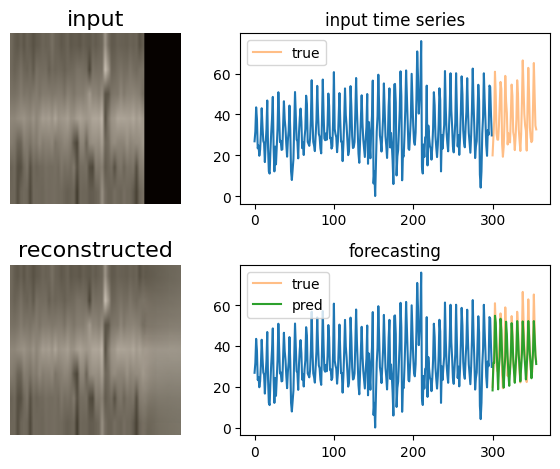

In [17]:
test_data, meta = dataset.get_gluonts_test_dataset("nn5_daily_without_missing")
periodicity_list = freq_to_seasonality_list(meta.freq)
periodicity = periodicity_list[0]
print(f"Data freq = {meta.freq}, possible periodicities = {periodicity_list}.")
print(f"We use P = {periodicity}.")

x = [x['target'] for x in test_data.input][0]
y = [x['target'] for x in test_data.label][0]
run(x[-300:], y, align_const=1.0, norm_const=0.4, periodicity=periodicity)

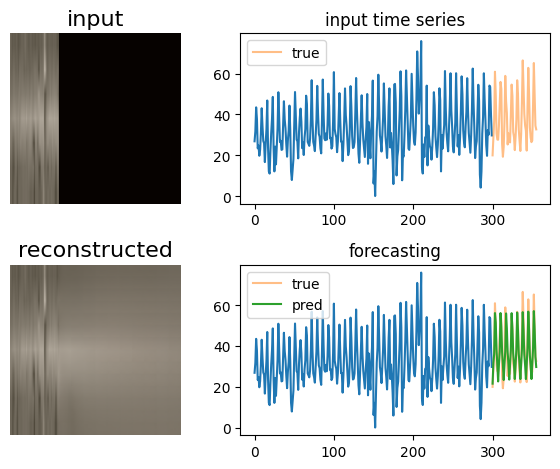

In [18]:
# Adjust align_const from 1.0 -> 0.4
run(x[-300:], y, align_const=0.4, norm_const=0.4, periodicity=periodicity)

- Example 2: A time series without significant periodicity, but with a clear trend.

Data freq = D, possible periodicities = [7, 30, 365, 1].
We use P = 1.


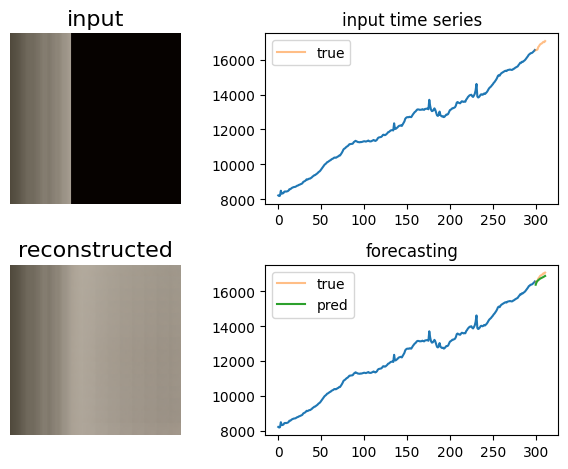

In [19]:
test_data, _ = dataset.get_gluonts_test_dataset("fred_md")
periodicity_list = freq_to_seasonality_list(meta.freq)
periodicity = periodicity_list[-1]
print(f"Data freq = {meta.freq}, possible periodicities = {periodicity_list}.")
print(f"We use P = {periodicity}.")

x = [x['target'] for x in test_data.input][0]
y = [x['target'] for x in test_data.label][0]

run(x[-300:], y, align_const=0.4, norm_const=0.4, periodicity=periodicity)

Visualization on more complicated examples can be found in Appendix D of our paper.